<header style="padding: 4em 0 0em 0">
    <img src="http://brentyi.github.io/filestore/ai4all_logo.svg" style="width: 30em; height: auto; margin: 0;" />
    <h3 style="margin: 1em 0 0 0;">
        <strong>Graphs I</strong>
        <span style="color: #777">
        &nbsp;&blacksquare;&nbsp;
        Robotics, Summer 2023</span>
    </h3>
</header>

<hr style="border-top: 0.4em solid #eee;" />

In this notebook, we'll take a whirlwind tour of graphs and graph search algorithms.

Our core goals will be to:
1. Understand how satelite images can correspond to 2D NumPy arrays.
2. Understand how fly-zone constraints can induce a traversable graph on these maps.
3. Implement the uniform cost search (breadth first search) algorithm to route a drone.

<hr style="border-top: 0.4em solid #eee;" />

In [ ]:
#@title Helper functions
import numpy as np
import matplotlib.pyplot as plt

def default_cmap(x):
    if x == 1:
        return [0, 255, 0]
    else:
        return [255, 0, 0]

def colored(A, cmap):
    im = np.zeros((A.shape[0], A.shape[1], 3), dtype=np.int)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            im[i, j] = cmap(A[i, j])
    return im

def visualize_adjacency(title, A):
    """Visualize an adjacency matrix using matplotlib.

    Args:
        title (str): Name of image we're visualizing.
        A (np.ndarray): Adjacency matrix we're visualizing.
    """
    assert type(title) == str, "Title not a string!"
    assert len(A.shape) == 2, "Image array not 2D!"

    plt.figure(figsize=(7, 7))

    # Visualize adjacency matrix
    # We manually set the black value with `vmin`, and the white value with `vmax`
    plt.imshow(A, vmin=0.0, vmax=1.0, cmap="gray")

    # Give our plot a title -- this is purely cosmetic!
    plt.title(f"{title}, shape={A.shape}")

    # Show image
    plt.show()

def visualize_map(title, M, A=None, start=None, end=None, path=None, cmap=default_cmap):
    """Visualize a 2D array using matplotlib.

    Args:
        title (str): Name of map we're visualizing.
        M (np.ndarray): Map we're visualizing. Shape should be `(rows, cols)`.
        A (np.ndarray): Adjacency matrix of graph.
    """
    assert type(title) == str, "Title not a string!"
    assert len(M.shape) == 2, "Map array not 2D!"

    plt.imshow(colored(M, cmap))
    if start is not None:
        plt.scatter(start[1], start[0], color="blue", label="start")
    if end is not None:
        plt.scatter(end[1], end[0], color="yellow", label="end")

    m, n = M.shape

    def ids(l):
        p = [l // n, l % n]
        return p

    def flip(t):
        return [t[1], t[0]]

    if A is not None:

        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                if A[i, j]:
                    # print(f"({i}, {j}) {ids(i)} -> {ids(j)}")
                    icoords = flip(ids(i))
                    jcoords = flip(ids(j))
                    x = [icoords[0], jcoords[0]]
                    y = [icoords[1], jcoords[1]]
                    plt.scatter(ids(i)[1], ids(i)[0], color="black")#, label=f"{i}")
                    plt.plot(x, y, color="black", alpha=0.5)#, label=f"{i} -> {j}")

    if path is not None:
        for i in range(len(path)-1):
            u, v = path[i], path[i+1]

            ucoords = flip(ids(u))
            vcoords = flip(ids(v))
            x = [ucoords[0], vcoords[0]]
            y = [ucoords[1], vcoords[1]]
            plt.plot(x, y, color="black", alpha=0.5)#, label=f"{i} -> {j}")

    if start or end:
        plt.legend()

    plt.title(title)
    plt.show()

def visualize_costs(title, M, costs, start=None, end=None):
    m, n = M.shape
    C = np.zeros(M.shape)
    for i in range(m):
        for j in range(n):
            C[i, j] = costs[i * n + j]

    if start is not None:
        plt.scatter(start[1], start[0], color="blue", label="start")
    if end is not None:
        plt.scatter(end[1], end[0], color="yellow", label="end")
    #np.max([x for x in costs if x != np.inf])
    plt.imshow(C)
    plt.colorbar()
    if start or end:
        plt.legend()
    plt.title(title)
    plt.show()

def plot_path(M, path):
    m, n = B.shape
    plt.imshow(colored(B, default_cmap))

    def ids(l):
        p = [l // m, l % m]
        return p

    def flip(t):
        return [t[1], t[0]]

    for i in range(len(p)-1):
        u, v = p[i], p[i+1]

        ucoords = flip(ids(u))
        vcoords = flip(ids(v))
        x = [ucoords[0], vcoords[0]]
        y = [ucoords[1], vcoords[1]]
        plt.plot(x, y, color="black", alpha=0.5)#, label=f"{i} -> {j}")


def visualize_path(M, p):
    # p is the path

    from IPython.display import HTML
    from matplotlib.animation import FuncAnimation
    from matplotlib.patches import Rectangle
    import matplotlib.pyplot as plt
    import numpy as np

    n = 2
    T = 5
    D = 0.4

    def interpolate(init, final):
        return np.tile(init, (1, T)) + (final - init) * np.linspace(0, 1, T)

    m, n = M.shape

    def ids(l):
        return [l // n, l % n]

    def flip(t):
        return [t[1], t[0]]

    ps = np.zeros((2, T * (len(p)-1)))
    for i in range(len(p)-1):
        u, v = p[i], p[i+1]
        ucoords = np.array(flip(ids(u))).reshape((2, 1))
        vcoords = np.array(flip(ids(v))).reshape((2, 1))
        ps[:, i*T:T*(i+1)] = interpolate(ucoords, vcoords)


    # from http://python4econ.blogspot.com/2013/03/matlabs-cylinder-command-in-python.html
    def cylinder(r, n):
        """
        Returns the unit cylinder that corresponds to the curve r.
        INPUTS:  r - a vector of radii
                 n - number of coordinates to return for each element in r

        OUTPUTS: x,y,z - coordinates of points
        """

        # ensure that r is a column vector
        r = np.atleast_2d(r)
        r_rows, r_cols = r.shape

        if r_cols > r_rows:
            r = r.T
        # find points along x and y axes
        points = np.linspace(0, 2 * np.pi, n + 1)
        x = np.cos(points) * r
        y = np.sin(points) * r

        # find points along z axis
        rpoints = np.atleast_2d(np.linspace(0, 1, len(r)))
        z = np.ones((1, n + 1)) * rpoints.T

        return x, y, z


    x, y, z = cylinder(D / 2, 100)
    x = x.squeeze()
    y = y.squeeze()
    z = z.squeeze()

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.close(fig)

    ax.axis("equal")
    #ax.axis([-1.5, 1.5, -1.5, 1.5])
    p_data = ax.plot(ps[0, :], ps[1, :], color="C0")[0]
    ax.scatter(ps[0, :], ps[1, :], color="C0", marker=".")

    ax.imshow(colored(M, default_cmap))
    def update(i):
        p_data.set_data(ps[0, i] + x, ps[1, i] + y)
        ax.set_title(f"i = {i}")


    ani = FuncAnimation(fig, update, interval=100, frames=T*(len(p) - 1))
    return HTML(ani.to_html5_video())

In [ ]:
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive/')
# drive_path = '/content/drive/My Drive/AI4ALL Robotics 2021/Colab notebooks/Graph assignment/' # path to fig folder
#from graph_helpers import visualize_adjacency, visualize_map, visualize_costs, visualize_path

## 1. Map to Matrix

<p>First, let's remember that we are taking a map like this:</p>

[Stanford overhead view](https://drive.google.com/file/d/1EiaSdBa1uxcL5tduT7jA58ZM4dXduHpB/view?usp=sharing)

<p>And we grid it up like this:</p>

[Stanford overhead view split into a grid](https://drive.google.com/file/d/1sZtc7jW-6OOmSJnEmJBIRknIgr4VSVJA/view?usp=sharing)

This looks like a two dimensional array, right?

Let's create a rectangular array with zeros.

<ipython-input-1-36a8ca557c06>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = np.zeros((A.shape[0], A.shape[1], 3), dtype=np.int)


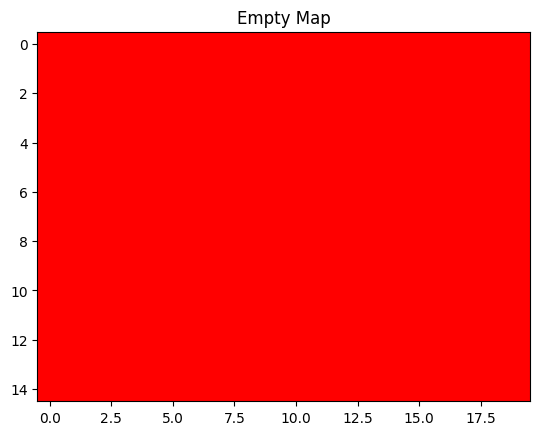

In [ ]:
a = np.zeros((15, 20))
visualize_map("Empty Map", a)

Why is it red? Well, we want the value `a[i, j]` to encode something about that cell.

When we were working with images, each cell had 3 numbers (in the case of RGB or HSL), but now it has one.

We decide what that number means. Here we are saying, visualize 0 as red!

Now let's see what color 1 is visualized as:

In [ ]:
b = np.zeros((15, 20))
b[0, 0] = 1

<ipython-input-1-36a8ca557c06>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = np.zeros((A.shape[0], A.shape[1], 3), dtype=np.int)


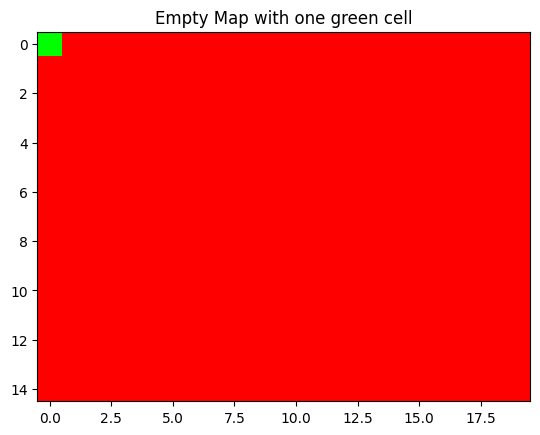

In [ ]:
visualize_map("Empty Map with one green cell", b)

Here we are saying to visualize the number 1 as green!

We can change the colors that are shown by the `visualize_map` function via the `cmap` named argument.

`cmap` takes a function that maps floats to lists of`[r,g,b]` values. See below.

Let's flip the colors:

<ipython-input-1-36a8ca557c06>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = np.zeros((A.shape[0], A.shape[1], 3), dtype=np.int)


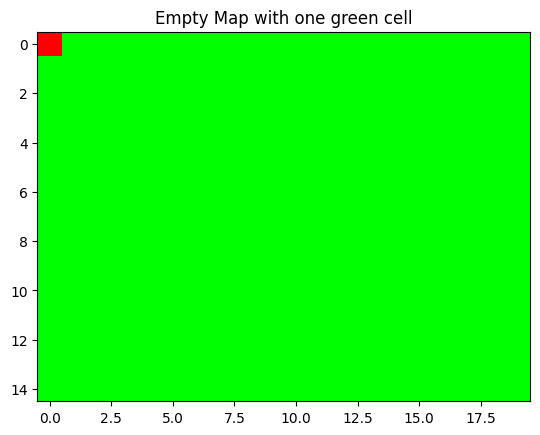

In [ ]:
def flipped_cmap(x):
    if x == 0:
        return [0, 255, 0]
    else:
        return [255, 0, 0]

visualize_map("Empty Map with one green cell", b, cmap=flipped_cmap)

Ok! So we have a "map" which is a numpy array and cells can be 0 or 1. We can visualize it.

Now let's go back to green and red, and use these to visualize where we can fly.

Think about green for grass and red for lava. We can walk on grass, but not on lava!

## 2. Types of Cells

<p>Suppose the following cells, indicated with a red dot are "flyable":</p>

[Stanford map with flyable grid](https://drive.google.com/file/d/1XHKsvrZmX61B89Q52UKyXAhJXto6CJwE/view?usp=sharing)

Let's visualize this flyable zone as green, and the unflyable as red

<ipython-input-1-36a8ca557c06>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = np.zeros((A.shape[0], A.shape[1], 3), dtype=np.int)


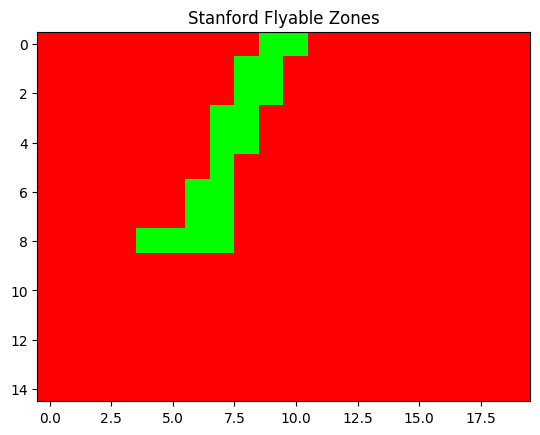

In [ ]:
stanford_map = np.zeros((15, 20))
stanford_map[0, 9:11] = 1
stanford_map[1, 8:10] = 1
stanford_map[2, 8:10] = 1
stanford_map[3, 7:9] = 1
stanford_map[4, 7:9] = 1
stanford_map[5, 7:8] = 1
stanford_map[6, 6:8] = 1
stanford_map[7, 6:8] = 1
stanford_map[8, 4:8] = 1
visualize_map("Stanford Flyable Zones", stanford_map)

So now we have a representation for a map.

Remember, we want to do search in this map, so now we will construct a graph.

## 3. Constructing the graph


<p>Since we can only fly in between flyable cells, we are going cells we can fly in as connected, and that induces an undirected graph!<p>

[Stanford grid with flyable cells connected with a graph](https://drive.google.com/file/d/198ZywW00nVq6jla6tbxGIBslAMi_8KcG/view?usp=sharing)

We can use this to build an adjacency matrix!

### a) Adjacency matrix review

Remember, adjacency matrices are two-dimensional numpy arrays. They are always square!

They have values which are either 0 or 1!

If the entry `i,j` is 1 that means there is an edge from `i` to `j`.

For undirected graphs, adjacency matrices are always symmetric!

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Adjacency Matrix Concept</div>

What is an adjacency matrix?

 * How do `1`s and `0`s correspond to edges in an undirected graph?
 * If our map is `m` by `n`, what is the size of the adjacency matrix?

> *Your response here!*

### b) Indexing

As the first piece, we need to think about how label the nodes of our graph. Since each cell in our `m` by `n` grid corresponds to a vertex, our graph has `mn` nodes!

Let's index vertices from left to right, top to bottom. So the top left cell is vertex 0 and the cell below it is vertex `n`. The cell below and to the right of the top left cell is vertex `n+1`.

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Vertices from Cells</div>
Complete the following function, `vertex_of_cell`, which gets the vertex number from  the cell indicies.

For example,
* `vertex_of_cell([0, 0]) == 0`
* `vertex_of_cell([0, 1]) == 1`
* `vertex_of_cell([1, 1]) == n+1`

In [ ]:
def vertex_of_cell(M, i, j):
    """Get the vertex of a cell

    Args:
        M (np.ndarray): the map we are working with.
        i (int): the row index.
        j (int): the column index.
    Return:
        vertex (int): the vertex
    """
    assert len(M.shape) == 2
    m, n = M.shape
    # YOUR CODE HERE
    # ***** Start of your code *****
    assert False, "Delete this line!"
    # ***** End of your code *****
    return vertex

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Cells from Vertices</div>
Now let's go the other direction, given a vertex let's get what indices it corresponds to in the map.


Complete the function `cell_of_vertex` which maps the vertex index to the cell indices!

Hint: remember `//` does integer division and `%` gets the remainder.

In [ ]:
def cell_of_vertex(M, k):
    """Get cell corresponding to the vertex.

    Args:
        M (np.ndarray): the map we are working with.
        k (int): the vertex index.

    Return:
        i (int): the row index.
        j (int): the column index.
    """
    assert len(M.shape) == 2
    m, n = M.shape

    # YOUR CODE HERE
    # ***** Start of your code *****

    # ***** End of your code *****
    return i,j

### c) Implementation

Now let's actually construct the adjacency matrix. Two vertices will be connected if they are each flyable!

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Constructing adjacency matrix from map</div>

Complete the function `adjacency_matrix`. Remember two cells should be connected by an edge in the graph if they are each flyable.

Also remember that the adjacency matrix for undirected graphs is symmetric, which means `A[i, j] = A[j, i]`.

Hint: you should probably loop over the cells!

In [ ]:
def adjacency_matrix(M, flyable=1):
    """Visualize a 2D array using matplotlib.
    All inputs values should be normalized 0.0-1.0.

    Args:
        M (np.ndarray): the map we are working with.
        flyable (int): what number indicates a flyable cell; defauls to 1.
    """
    assert len(M.shape) == 2
    # Size of map
    m, n = M.shape

    # Number of vertices
    o = m * n

    # A for *A*djacency matrix
    A = np.zeros((o, o))

    # YOUR CODE HERE
    # ***** Start of your code *****
    assert False, "Delete this line!"
    # ***** End of your code *****

    return A

In [ ]:
stanford_adjacency = adjacency_matrix(stanford_map)

AssertionError: ignored

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Adjacency Matrix</div>

Run the following code cell to visualize the entries, what do you see?

> *Your response here!*

In [ ]:
visualize_adjacency("Stanford Adjacency Matrix", stanford_adjacency)

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Graph on map visualization</div>

The `visualize_map` function can also take an adjacency matrix to visualize via the named `A` argument.

Run the following code cell to visualize it, what do you see? Is this harder or easier to interpret than the adjacency matrix itself?

> *Your response here!*

In [ ]:
visualize_map("Stanford Flyable Zones Connected", stanford_map, A=stanford_adjacency)

## 4. Finding Neighbors

### a) The neighbors of a vertex...

The set neighbors of a node in an undirected graph are those nodes which are connected to it by an edge!

Let's write a function that get's the neighbors of vertices

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Neighbors</div>

Complete the following function to get the neighbors of vertex `k`.

In [ ]:
def neighbors(A, k):
    """Get the neighbors of vertex `i`

    Args:
        A (np.ndarray): Adjacency matrix
        i (int): vertex we care about.
    """
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]

    # we have o vertices
    o = A.shape[0]
    assert k < o

    # ***** Start of your code *****
    assert False, "Delete this line!"
    # ***** End of your code *****

Does vertex 0, the top left have any neighbors?

In [ ]:
assert neighbors(stanford_adjacency, 0) == []

Does vertex 29?

In [ ]:
assert neighbors(stanford_adjacency, 29) == [9, 28, 49]

## 5. Sidebar: Queues

We are headed towards search algorithms! But a quick detour...we need to talk about queues!

### a) Queues...
Remember, queues are useful for storing a list of elements, with the semantics FIFO or LIFO.

* FIFO stands for first in first out; the item which was added to the queue earliest will be the next to be popped.
* LIFO stands for last in first out; the item which was most recently added to the queue will be the next to be popped.

People often call LIFO queues **stacks** and call FIFO queues just **queues**. In lecture, we also saw priority queues, in which the queue elements are associated with a priority value, and popping gives the highest priority element.

For the search algorithm we will implement, we only need FIFO queues, which we will call queues.

### b) Queues via lists

For us, a queue is just a list:

In [ ]:
queue = []

We can append (or push or add) to the queue

In [ ]:
queue.append(1)
queue.append(2)
queue

We can remove (or pop or get) from the queue

In [ ]:
elem = queue.pop(0)
print(f"popped {elem} from queue which is now {queue}")

In [ ]:
elem = queue.pop(0)
print(f"popped {elem} from queue which is now {queue}")

What happens if we pop from a queue when it's empty? Uncomment the next line to find out!

In [ ]:
# elem = queue.pop(0)

So in general, we might need to check:

In [ ]:
if len(queue) > 0:
    print("can pop")
else:
    print("can't pop")

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Queue Basics</div>

Because of this let's write two functions:

* one called `push` to add elements to a queue
* one called `pop` to get an element and shorten the queue

Hint: `push` is one line! `pop` requires an `if` statement checking the length of the queue!

In [ ]:
def push(q, elem):
    """Add an element to the queue

    Args:
        q (list): the queue.
        elem (Any): the element to add.
    """
    # YOUR CODE HERE
    # ***** Start of your code *****
    assert False, "Delete this line!"
    # ***** End of your code *****

def pop(q):
    """Get an element from a queue, if there are any.
    If there is nothing in the queue, return the value None.

    Args:
        q (list): the queue.
    Returns:
        obj
    """

    # YOUR CODE HERE
    # ***** Start of your code *****
    assert False, "Delete this line!"
    # ***** End of your code *****

test_list = [1, 2, 3, 4, 5]
push(test_list, 6)
assert len(test_list) == 6
assert test_list[-1] == 6
assert pop(test_list) == 1
assert len(test_list) == 5

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Using `push` and `pop`</div>

In the following cell, create a queue. Push (1,2), (3,4), (5,6) to it, then pop from the queue twice, then push (11,12).

What does the queue contain?
> *Your response here!*

In [ ]:
queue = []
# YOUR CODE HERE
# ***** Start of your code *****
assert False, "Delete this line!"
# ***** End of your code *****
print(queue)

That was our whole sidebar! We will use queues to keep track of our search in the graph!

## STOP HERE FOR DAY 1! We will continue this tomorrow :)

## 6. Search

Remember we will be searching through the graph.

We will have a designated start vertex, and we are interested in the distances to all the other vertices. If we have to travel two edges to get from vertex `u` to vertex `v` we will say that these the cost of going from `u` to `v` is 2.

Review the lecture slides for the breadth first search algorithm.

### a) Implementation

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Uniform Cost Search</div>

Complete the implementation of the uniform cost search algorithm before.


We have declared some variables to get you started, including:
 * `costs` the vector of costs
 * `queue` the search queue; store tuples of `(vertex,cost)` on the queue.
 * `seen` the dictionary of already-seen nodes; use to only add vertices to the queue once.

Hint: loop while there is still something in the queue, and pop an element off; get the vertex it references and the cost. Mark it as seen. If it is the goal, return the costs. Otherwise, loop over its neighbors and add then ones we have not yet seen to the queue with cost one higher than the current cost. Once the queue is empty, return the costs.

In [ ]:
def uniform_cost_search(A, start, goal):
    """Perform a breadth first search, returning distances from nodes.
       If goal is specified, return costs once goal is found.
       If the distance to the node is np.inf, then the nodes are unconnected in the graph.

    Args:
        A (np.ndarray): Adjacency matrix representing graph to search.
        start (int): vertex to start search at.
        goal (int): vertex indicating goal node.
    """
    # o is the number of nodes
    o = A.shape[0]

    # costs (or distances of path to node)
    # inf represents that these nodes are not connected.
    costs = np.inf * np.ones((o,))

    # Begin our search at start node start, which is distance 0
    queue = [(start, 0)]

    # Dictionary of nodes we have already seen.
    # keys are ints, and values are booleans.
    seen = {}

    # YOUR CODE HERE
    # ***** Start of your code *****
    assert False, "Delete this line!"
    # ***** End of your code *****
    return costs

### b) A search

Let's search for a path from cell [0, 10] to cell [8, 4]

In [ ]:
stanford_start = [0, 10]
stanford_end = [8, 4]

Let's visualize this.

In [ ]:
visualize_map("Start to End", stanford_map, start=stanford_start, end=stanford_end)

We need these as vertices

In [ ]:
stanford_start_vertex = vertex_of_cell(stanford_map, stanford_start[0], stanford_start[1])
stanford_end_vertex = vertex_of_cell(stanford_map, stanford_end[0], stanford_end[1])

We can use our function!

In [ ]:
stanford_costs = uniform_cost_search(
    stanford_adjacency,
    stanford_start_vertex,
    stanford_end_vertex,
)

We can use a helper function to visualize the costs! Yellow is higher!

In [ ]:
visualize_costs(
    "Distances from Start on Stanford Map",
    stanford_map,
    stanford_costs,
    start=stanford_start,
    end=stanford_end,
)

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Cost Visualization</div>

Which color corresponds to a far distance from the start?

> *Your response here*

### c) Path reconstruction

Now that we have the shortest distances to each vertex, we need to construct the shortest path!

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Shortest Neighbor</div>

Given a vertex `k` we want to find the neighbor of this vertex that has the smallest cost.

Complete the `shortest_neighbor` function.

In [ ]:
def shortest_neighbor(A, costs, k):
    """Find the neighbor to vertex `k` with the shortest distance.

    Args:
        A (np.ndarray): Adjacency matrix representing graph.
        costs (np.ndarray): costs to each vertex from some start node.
        k (int): vertex whose neighbors we should consider
    """
    # YOUR CODE HERE
    # ***** Start of your code *****
    assert False, "Delete this line!"
    # ***** End of your code *****

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Shortest Path</div>

Complete the function `shortest_path`. You should use your `shortest_neighbor` function.

Hint: Start at the goal, find the cheapest neighbor, then find the cheapest neighbor of that neighbor, and so on...

In [ ]:
def shortest_path(A, costs, start, goal):
    """Find the shortest_path to goal from start. Costs are distances from start.

    Args:
        A (np.ndarray): Adjacency matrix representing graph.
        costs (np.ndarray): costs (distances) to each vertex from `start`.
        start (int): vertex to start at.
        goal (int): vertex to reach.
    """

    # YOUR CODE HERE
    # ***** Start of your code *****
    assert False, "Delete this line!"
    # ***** End of your code *****

Let's use this function to compute the path...

In [ ]:
stanford_path = shortest_path(
    stanford_adjacency,
    stanford_costs,
    stanford_start_vertex,
    stanford_end_vertex,
)
print(stanford_path)

We can use the helper `visualize_map` function with keyword argument `path` to visualize the path as well!

In [ ]:
visualize_map("Start to End", stanford_map, start=stanford_start, end=stanford_end, path=stanford_path)

Nice! But let's see the drone **fly**!

In [ ]:
print(stanford_path)

In [ ]:
visualize_path(stanford_map, stanford_path)

For your project you can try this on much more complicated maps, or on maps constructed from satellite imagery. Additionally, you can try more sophisticated graph search algorithms!

## 7. Mystery Map

To see how all our code can work on any map, try out this mystery map!

In [ ]:
mystery_map = np.array([
    [0, 0, 0, 0, 0,],
    [1, 1, 1, 1, 1,],
    [1, 0, 0, 1, 0,],
    [1, 0, 1, 1, 0,],
    [1, 1, 1, 1, 1],
])
mystery_start = [4, 0]
mystery_end = [1, 4]

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Visualize Mystery Map and the Start/End</div>

Write code to visualize the mystery map with start and end goals!

In [ ]:
# YOUR CODE HERE
# ***** Start of your code *****
assert False, "Delete this line!"
# ***** End of your code *****

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Find and Visualize Path on Mystery Map</div>

Write code to visualize the mystery map with start and end goals!

Hint: It involves several lines, but they are the same as what we did for the Stanford map!

### a) Computing and Visualizing Costs

In [ ]:
# YOUR CODE HERE
# ***** Start of your code *****
assert False, "Delete this line!"
# ***** End of your code *****

### b) Compute and Visualizing

...using `shortest_path` and `visualize_map`!

In [ ]:
# YOUR CODE HERE
# ***** Start of your code *****
assert False, "Delete this line!"
# ***** End of your code *****

### c) Animation Visualization

Finally, we can use `visualize_path` to animate the flight!

In [ ]:
visualize_path(mystery_map, mystery_path)

Congratulations, you've completed a whirlwind tour of graphs and graph search algorithms!